In [111]:
#!git clone https://github.com/anm-ol/LearningDeep
#!mv LearningDeep/data ./
#!cp **/*.pth ./model_weights

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#!mv drive/MyDrive/model_weights ./


In [112]:
import torch
torch.cuda.get_device_name(0)

from torchvision.datasets import Flickr8k
from torchvision.transforms import PILToTensor
from torchvision.transforms import ToTensor
# Specify the root directory where the dataset will be saved
root = "./data/flickr8k/Images/"

# Download the dataset if it doesn't exist
#Flickr8k(root,annFile= './data/flickr8k/annotations/captions_train.json', transform=ToTensor)

# Load the dataset
dataset = Flickr8k(root,ann_file= './data/flickr8k/captions.txt', transform=PILToTensor)


# Accessing the image and caption at index 0
#image, caption = dataset[0]

In [113]:
import pandas as pd
ann = pd.read_csv('./data/flickr8k/captions.txt', delimiter=',', header=None, names=['image', 'caption'])
captions = ann['caption'].to_list()
ann['image'][0] = ann['image'][1]
ann['caption'][0] = ann['caption'][1]

In [114]:
import re
from collections import Counter

def separate(text):
    # Convert to lowercase and split into words
    # Keep special symbols as separate tokens
    return re.findall(r'\w+|[^\w\s]', text.lower())

def tokenize(text):
    return [stoi.get(token, stoi['UNK']) for token in separate(text)]

# Assuming 'captions' is a list of caption strings
all_words = []
for caption in captions:
    all_words.extend(separate(caption))

# Count word frequencies
word_counts = Counter(all_words)

# Define special tokens
special_tokens = ['START', 'END', 'PAD', 'UNK']

# Build vocabulary of unique words (special tokens first, then sorted by frequency, descending)
vocab = special_tokens + [word for word in sorted(word_counts, key=word_counts.get, reverse=True) if word not in special_tokens]

# Create mappings
stoi = {word: i for i, word in enumerate(vocab)}
itos = {i: word for i, word in enumerate(vocab)}

print(itos)


{0: 'START', 1: 'END', 2: 'PAD', 3: 'UNK', 4: 'a', 5: '.', 6: 'in', 7: 'the', 8: 'on', 9: 'is', 10: 'and', 11: 'dog', 12: 'with', 13: 'man', 14: 'of', 15: 'two', 16: 'white', 17: 'black', 18: 'boy', 19: 'are', 20: 'woman', 21: 'girl', 22: ',', 23: 'to', 24: 'wearing', 25: 'at', 26: 'people', 27: 'water', 28: 'red', 29: 'young', 30: 'brown', 31: 'an', 32: 'his', 33: 'blue', 34: 'dogs', 35: 'running', 36: 'through', 37: 'playing', 38: 'while', 39: 'shirt', 40: 'down', 41: 'standing', 42: 'ball', 43: 'little', 44: 'grass', 45: 'snow', 46: 'child', 47: 'person', 48: 'jumping', 49: 'over', 50: 'three', 51: 'front', 52: 'sitting', 53: 'holding', 54: 'up', 55: 'field', 56: 'small', 57: 'by', 58: 'large', 59: 'green', 60: 'one', 61: 'group', 62: 'yellow', 63: 'her', 64: 'walking', 65: 'children', 66: 'men', 67: '-', 68: 'into', 69: 'air', 70: 'beach', 71: 'near', 72: 'mouth', 73: 'jumps', 74: 'another', 75: 'for', 76: 'street', 77: 'runs', 78: 'its', 79: 'from', 80: 'riding', 81: 'stands', 82:

In [115]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

def display_image(image_name):
    image = Image.open('./data/flickr8k/Images/' + image_name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def get_image_data(image_name):
    image = Image.open('./data/flickr8k/Images/' + image_name)
    image = PILToTensor()(image)/255
    return image

def resize_image(img_data, size):
    resized_img = transforms.Resize(size)(img_data)
    return resized_img

def get_batch(batch_size=1):
    rand = np.random.randint(1, len(ann), (batch_size))
    img, caption = [resize_image(get_image_data(ann['image'][i]), (320, 320)) for i in rand], [ann['caption'][i] for i in rand]
    caption = [torch.tensor([stoi[token] for token in caption[i]]) for i in range(batch_size)]
    batch = torch.stack(img)
    return batch, caption

def get_batch(data, batch_size=1):
    if data is not None:
        rand = np.random.randint(1, len(data), (batch_size))
        img, caption = [(data[0][i]) for i in rand], [data[1][i] for i in rand]
        batch = torch.stack(img)
    else:
        rand = np.random.randint(1, len(ann), (batch_size))
        img, caption = [resize_image(get_image_data(ann['image'][i]), (320, 320)) for i in rand], [ann['caption'][i] for i in rand]
        caption = [torch.tensor([stoi[token] for token in caption[i]]) for i in range(batch_size)]
        batch = torch.stack(img)
    return batch, caption

In [116]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import torch
import os
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

class FlickrDataset(Dataset):
    def __init__(self, root_dir, ann, transform=None):
        self.root_dir = root_dir
        self.ann = ann
        self.transform = transform

    def __len__(self):
        return len(self.ann)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.ann['image'][idx])
        image = Image.open(img_name).convert('RGB')
        caption = self.ann['caption'][idx]

        if self.transform:
            image = self.transform(image)

        caption = torch.tensor(tokenize(caption))
        return image, caption

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)

    # Pad captions to the length of the longest caption in the batch
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=stoi['PAD'])

    # Create a mask for valid caption lengths
    caption_lengths = torch.tensor([len(cap) for cap in captions])
    mask = (captions_padded != 0).float()

    return images, captions_padded, caption_lengths, mask

def get_data_loader(train_size=100, batch_size=32, num_workers=4, train= True):
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
    ])

    dataset = FlickrDataset('./data/flickr8k/Images/', ann[: int(len(ann)*0.8)], transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)

    return dataloader

In [117]:
root_dir = './data/flickr8k/Images/'  # Update this to your image directory
train_loader = get_data_loader(train_size=100, batch_size=4, num_workers=0)

for batch, captions,_,_ in train_loader:
    print(f"Batch shape: {batch.shape}, Caption length: {(captions).shape}")
    break  # Just print the first batch

print("DataLoader initialized successfully!")

Batch shape: torch.Size([4, 3, 320, 320]), Caption length: torch.Size([4, 15])
DataLoader initialized successfully!


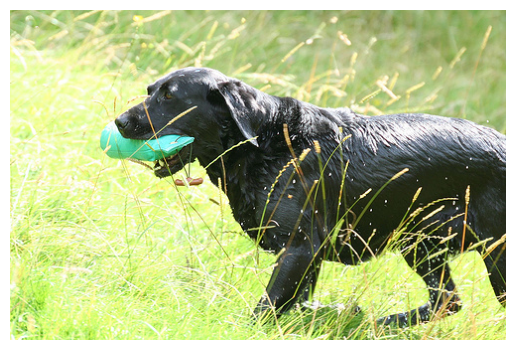

A wet black dog is carrying a green toy through the grass .


In [118]:
import time
import IPython.display as display

for i in range(100, 120, 5):
    display_image(ann.get('image')[i])
    data = get_image_data(ann.get('image')[i])
    print(ann.get('caption')[i])
    time.sleep(0.5)

    display.clear_output(wait=True)

In [202]:
import torch.nn as nn
# Define the model
class CNNModel(nn.Module):
    def __init__(self, out_size):
        super(CNNModel, self).__init__()
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.bnorm0 = nn.BatchNorm1d(128*20*20)
        self.fc1 = nn.Linear(128*20*20, 1024)
        self.bnorm1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, out_size)
        self.bnorm2 = nn.BatchNorm1d(out_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv12(self.relu(self.conv11(x)))
        x = self.pool(self.relu(x))
        x = self.conv22(self.relu(self.conv21(x)))
        x = self.pool(self.relu(x))
        x = self.conv32(self.relu(self.conv31(x)))
        x = self.pool(self.relu(x))
        x = self.conv4(x)
        x = self.pool(self.relu(x))
        x = x.view(-1, 128*20*20)

        x = self.relu(self.bnorm0(x))
        x = self.fc1(x)
        x = self.bnorm1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        return x

class RNNmodel(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(RNNmodel, self).__init__()
        self.rnn = nn.RNN(input_size = emb_size, hidden_size = hidden_size, num_layers=1,nonlinearity='relu', batch_first=True)
        self.emb = nn.Embedding(len(stoi), emb_size)
        self.final = nn.Linear(hidden_size, len(stoi))
        self.cross_entropy = nn.CrossEntropyLoss(ignore_index=stoi['PAD'])

    def forward(self, x, hidden, target):
        x = self.emb(x)
        if len(x.shape) == 3:
            hidden = hidden.unsqueeze(0)
        x, _ = self.rnn(x, hidden)
        #view_weights(x.reshape(-1))
        x = self.final(x)
        #view_weights(x.reshape(-1))

        if target is not None:
            # Reshape x to (batch_size * sequence_length, num_classes)
            x_reshaped = x.view(-1, x.size(-1))
            # Reshape target to (batch_size * sequence_length)
            target_reshaped = target.view(-1)
            loss = self.cross_entropy(x_reshaped, target_reshaped)
        return x, loss

    def sample(self, x, hidden, max_len=20):
        x = self.emb(x)
        x, hidden = self.rnn(x, hidden)
        x = self.final(x)
        return x, hidden


In [203]:
import torch.nn.functional as F
def sample_caption(cnn_model, rnn_model, image, temperature = 1, max_length=100):
    # Set the models to evaluation mode
    cnn_model.eval()
    rnn_model.eval()
    # Extract features from the image using the CNN model
    with torch.no_grad():
        features = cnn_model(image.unsqueeze(0))  # Add batch dimension
    # Initialize the caption with the <START> token
    caption = [stoi['START']]
    hidden = features.unsqueeze(0)
    hidden_plot = hidden.view(-1).cpu()
    plt.figure(figsize=(3, 2))
    plt.plot(range(hidden_plot.shape[0]), hidden_plot.detach().numpy())
    plt.show()
    for _ in range(max_length):
        # Convert the current caption to a tensor
        caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)  # Add batch dimension
        # Generate the next word using the RNN model
        with torch.no_grad():
            output, hidden = rnn_model.sample(caption_tensor, hidden)
        # Apply temperature and sample from the output distribution
        scaled_output = output.squeeze(0)[-1] / temperature
        probs = F.softmax(scaled_output, dim=-1)
        next_word_idx = torch.multinomial(probs, 1).item()
        # Append the next word to the caption
        caption.append(next_word_idx)
        # Stop if the <END> token is generated
        if next_word_idx == stoi['END']:
            break

    # Convert the caption indices to words
    caption_words = [itos[idx] for idx in caption]
    return ' '.join(caption_words)

def train_model(cnn, rnnmodel, dataset, epochs=10):
    params = list(cnn.parameters()) + list(rnnmodel.parameters())
    optimizer = torch.optim.Adam(params, lr=0.03)
    for epoch in range(epochs):
        total_loss = 0
        for i in range(5000):
            image, caption = get_batch()
            optimizer.zero_grad()
            features = cnn(image)
            target = torch.cat((caption[0], torch.tensor([stoi['<END>']])), 0)
            caption = torch.cat((torch.tensor([stoi['<START>']]), caption[0]), 0)
            output, loss = rnnmodel(caption, features, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if i % 10 == 0:
                print(f'Epoch {epoch}, Loss: {total_loss/10}')
                total_loss = 0
                #print(sample_caption(output))

def train_model_batch(cnn, rnnmodel, train_loader, captions, num_iter = -1, lr=0.001, batch_size=4, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move models to the GPU
    cnn = cnn.to(device)
    rnnmodel = rnnmodel.to(device)
    cnn.train()
    rnnmodel.train()
    train_loader = get_data_loader(batch_size=batch_size, num_workers=0, train=True)

    params = list(cnn.parameters()) + list(rnnmodel.parameters())
    optimizer = torch.optim.AdamW(params, lr=lr)

    cap_copy = captions.clone().to(device)  # Move captions to GPU
    for epoch in range(epochs):
        total_loss = 0
        i = 0
        for batch, captions, cap_len, _ in train_loader:
            # Move input data to GPU
            image = batch.to(device)
            captions = captions.to(device)
            cap_len = cap_len.to(device)

            optimizer.zero_grad()
            # Forward pass through CNN
            features = cnn(image).to(device)
            # Initialize target and move to GPU
            target = torch.zeros(captions.shape[0], captions.shape[1] + 1, device=device)
            for j in range(len(batch)):
                length = cap_len[j]
                target[j] = torch.cat((captions[j][:length], torch.tensor([stoi['END']], device=device), captions[j][length:]))

            cap_copy = torch.cat((torch.zeros(len(batch), 1, device=device), captions), dim=1).long()
            target = target.long()
            # Forward pass through RNN
            output, loss = rnnmodel(cap_copy, features, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if (i+1) % 1 == 0:
                print(f'Epoch {epoch}, Iter: {i}, Loss: {total_loss/1:.4f}')
                total_loss = 0
            if i == num_iter:
                break
            i += 1

In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [205]:
cnn = CNNModel(256)
rnnmodel = RNNmodel(512, 256)
params = list(cnn.parameters()) + list(rnnmodel.parameters())
sum(p.nelement() for p in params)/ 1000000 # number of parameters in total

59.682123

In [206]:
print(torch.cuda.memory_allocated(0) / 1e9)
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated() / 1e9)

1.861139456
1.861139456


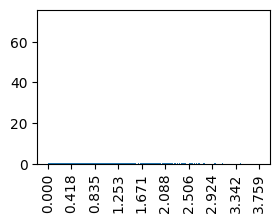

Mean: 0.404218, Variance: 0.397158 Max: 3.759193
Epoch 0, Iter: 0, Loss: 9.0157


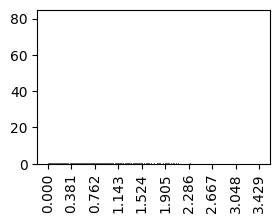

Mean: 0.399372, Variance: 0.387352 Max: 3.429072
Epoch 0, Iter: 1, Loss: 8.7642


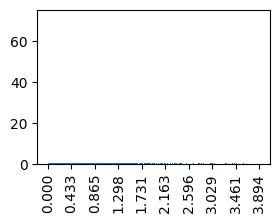

Mean: 0.392217, Variance: 0.380506 Max: 3.894186
Epoch 0, Iter: 2, Loss: 8.4677


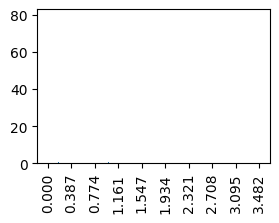

Mean: 0.410662, Variance: 0.395607 Max: 3.481870
Epoch 0, Iter: 3, Loss: 8.0772


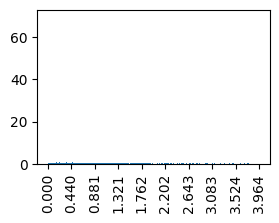

Mean: 0.378435, Variance: 0.402143 Max: 3.964117
Epoch 0, Iter: 4, Loss: 7.7763


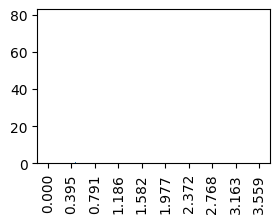

Mean: 0.400379, Variance: 0.410013 Max: 3.558575
Epoch 0, Iter: 5, Loss: 7.4395


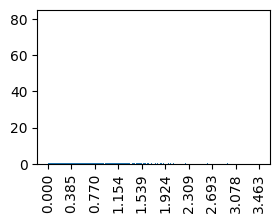

Mean: 0.406110, Variance: 0.400565 Max: 3.462962
Epoch 0, Iter: 6, Loss: 6.7909


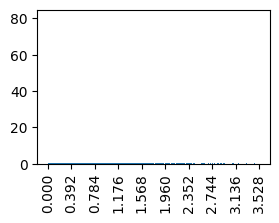

Mean: 0.399001, Variance: 0.412714 Max: 3.527619
Epoch 0, Iter: 7, Loss: 6.1694


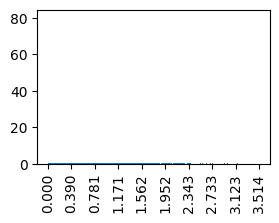

Mean: 0.416709, Variance: 0.415116 Max: 3.513792
Epoch 0, Iter: 8, Loss: 6.4926


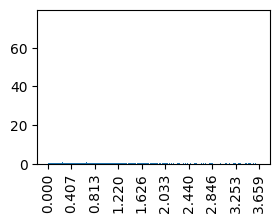

Mean: 0.382207, Variance: 0.416931 Max: 3.659360
Epoch 0, Iter: 9, Loss: 5.9680


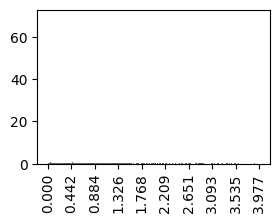

Mean: 0.375061, Variance: 0.409367 Max: 3.977083
Epoch 0, Iter: 10, Loss: 5.5007


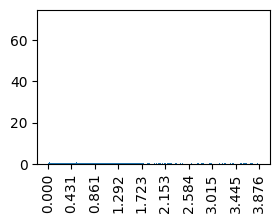

Mean: 0.371200, Variance: 0.397789 Max: 3.876143
Epoch 0, Iter: 11, Loss: 5.6739


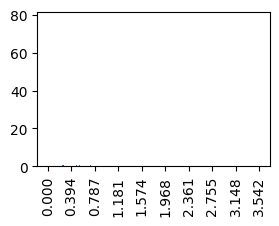

Mean: 0.402719, Variance: 0.388167 Max: 3.541677
Epoch 0, Iter: 12, Loss: 5.4523


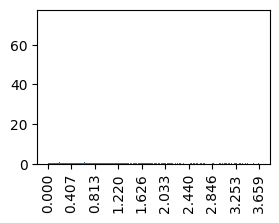

Mean: 0.381306, Variance: 0.381592 Max: 3.659312
Epoch 0, Iter: 13, Loss: 5.3264


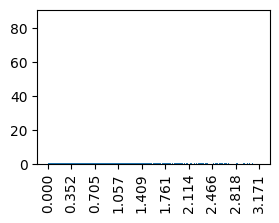

Mean: 0.413041, Variance: 0.402953 Max: 3.170658
Epoch 0, Iter: 14, Loss: 5.3642


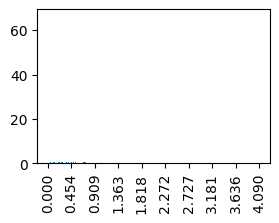

Mean: 0.362862, Variance: 0.364480 Max: 4.090063
Epoch 0, Iter: 15, Loss: 5.4032


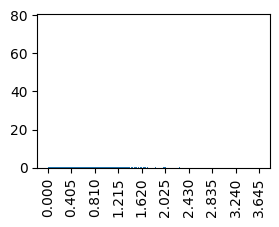

Mean: 0.411242, Variance: 0.390777 Max: 3.644629
Epoch 0, Iter: 16, Loss: 5.5483


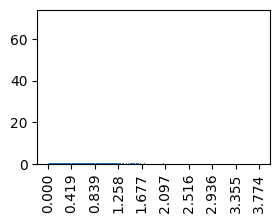

Mean: 0.382081, Variance: 0.370353 Max: 3.774335
Epoch 0, Iter: 17, Loss: 5.5058


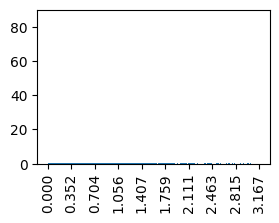

Mean: 0.410301, Variance: 0.364974 Max: 3.166785
Epoch 0, Iter: 18, Loss: 5.3144


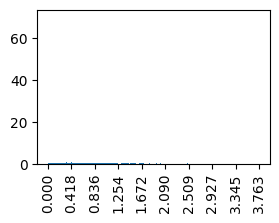

Mean: 0.395202, Variance: 0.358258 Max: 3.762796
Epoch 0, Iter: 19, Loss: 4.7768


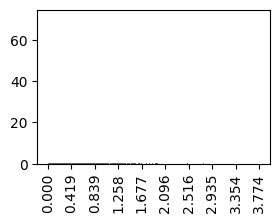

Mean: 0.395626, Variance: 0.371845 Max: 3.773653
Epoch 0, Iter: 20, Loss: 5.0011


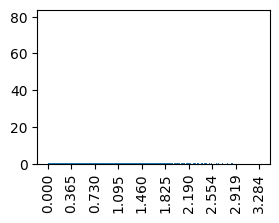

Mean: 0.405669, Variance: 0.347753 Max: 3.284330
Epoch 0, Iter: 21, Loss: 5.4879


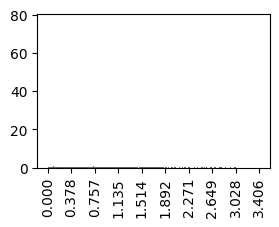

Mean: 0.391219, Variance: 0.342157 Max: 3.406366
Epoch 0, Iter: 22, Loss: 5.5258


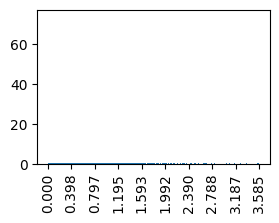

Mean: 0.382895, Variance: 0.346531 Max: 3.585059
Epoch 0, Iter: 23, Loss: 5.1483


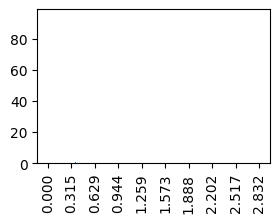

Mean: 0.409026, Variance: 0.350080 Max: 2.831747
Epoch 0, Iter: 24, Loss: 4.7537


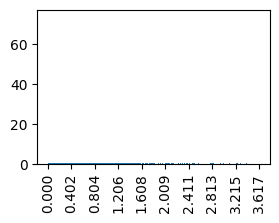

Mean: 0.399873, Variance: 0.351464 Max: 3.617070
Epoch 0, Iter: 25, Loss: 4.9140


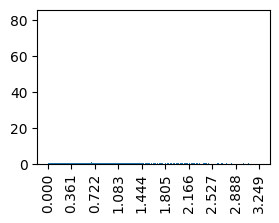

Mean: 0.403273, Variance: 0.356473 Max: 3.249326
Epoch 0, Iter: 26, Loss: 4.5311


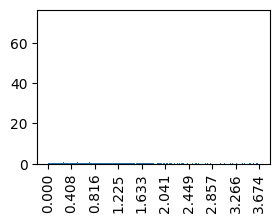

Mean: 0.381724, Variance: 0.362279 Max: 3.673869
Epoch 0, Iter: 27, Loss: 5.1686


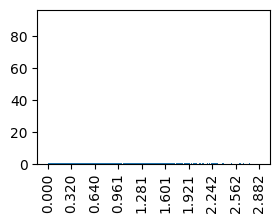

Mean: 0.411790, Variance: 0.357458 Max: 2.882223
Epoch 0, Iter: 28, Loss: 4.5960


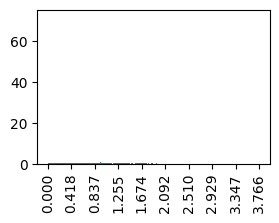

Mean: 0.415960, Variance: 0.365968 Max: 3.765592
Epoch 0, Iter: 29, Loss: 4.9698


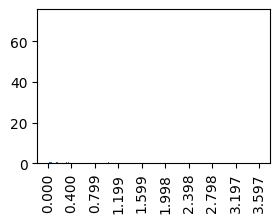

Mean: 0.393038, Variance: 0.345718 Max: 3.596951
Epoch 0, Iter: 30, Loss: 4.7382


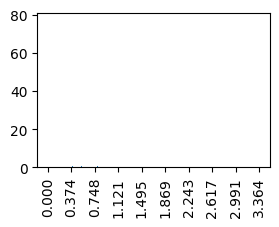

Mean: 0.400445, Variance: 0.340767 Max: 3.364362
Epoch 0, Iter: 31, Loss: 4.5637


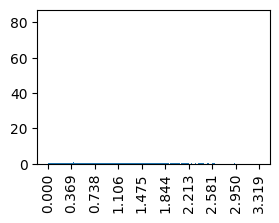

Mean: 0.403087, Variance: 0.362272 Max: 3.318886
Epoch 0, Iter: 32, Loss: 4.9125


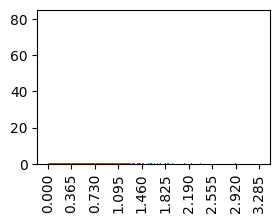

Mean: 0.403573, Variance: 0.352308 Max: 3.285247
Epoch 0, Iter: 33, Loss: 4.4811


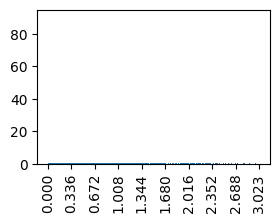

Mean: 0.406434, Variance: 0.362183 Max: 3.023489
Epoch 0, Iter: 34, Loss: 4.3835


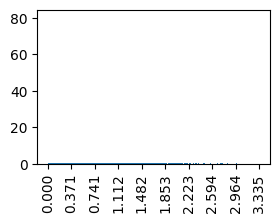

Mean: 0.415654, Variance: 0.358081 Max: 3.334532
Epoch 0, Iter: 35, Loss: 4.5289


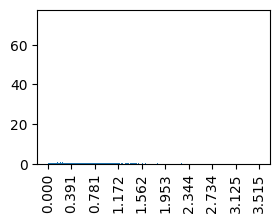

Mean: 0.380681, Variance: 0.335173 Max: 3.515378
Epoch 0, Iter: 36, Loss: 5.4902


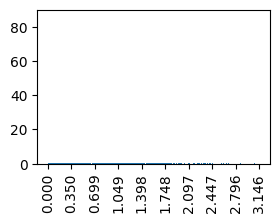

Mean: 0.408471, Variance: 0.345191 Max: 3.145628
Epoch 0, Iter: 37, Loss: 4.3602


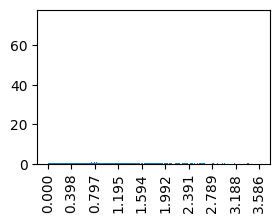

Mean: 0.403846, Variance: 0.347002 Max: 3.586401
Epoch 0, Iter: 38, Loss: 4.3595


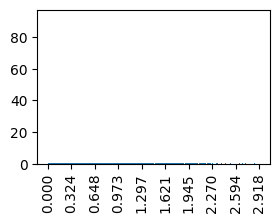

Mean: 0.411018, Variance: 0.352197 Max: 2.918078
Epoch 0, Iter: 39, Loss: 4.5040


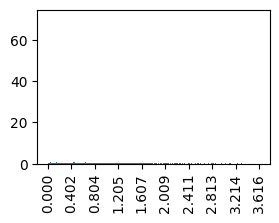

Mean: 0.381440, Variance: 0.324534 Max: 3.616119
Epoch 0, Iter: 40, Loss: 4.8986


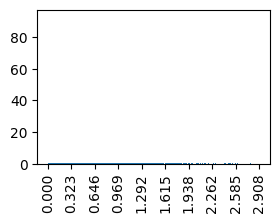

Mean: 0.414928, Variance: 0.352670 Max: 2.907649
Epoch 0, Iter: 41, Loss: 4.4878


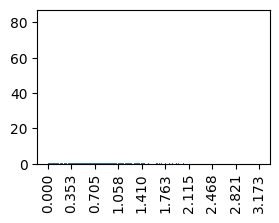

Mean: 0.389912, Variance: 0.329316 Max: 3.173099
Epoch 0, Iter: 42, Loss: 4.2494


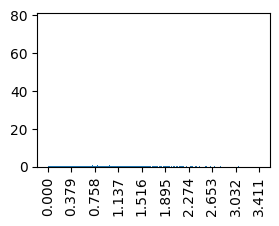

Mean: 0.423410, Variance: 0.345902 Max: 3.410965
Epoch 0, Iter: 43, Loss: 4.5760


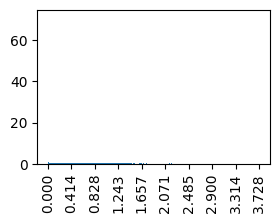

Mean: 0.391220, Variance: 0.332066 Max: 3.728153
Epoch 0, Iter: 44, Loss: 4.5954


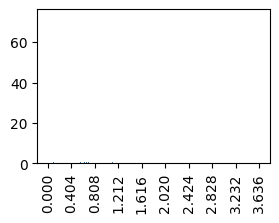

Mean: 0.385000, Variance: 0.340564 Max: 3.635751
Epoch 0, Iter: 45, Loss: 4.4265


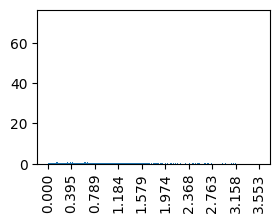

Mean: 0.385953, Variance: 0.326861 Max: 3.552719
Epoch 0, Iter: 46, Loss: 4.7407


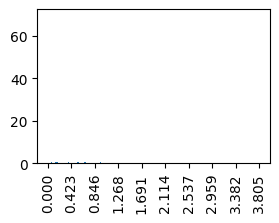

Mean: 0.370860, Variance: 0.336433 Max: 3.804848
Epoch 0, Iter: 47, Loss: 4.5738


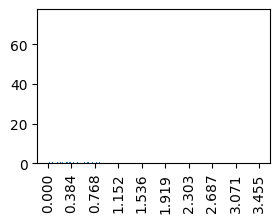

Mean: 0.370061, Variance: 0.330880 Max: 3.454925
Epoch 0, Iter: 48, Loss: 4.5853


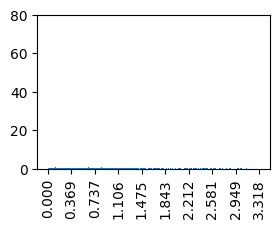

Mean: 0.383691, Variance: 0.342175 Max: 3.317996
Epoch 0, Iter: 49, Loss: 4.4468


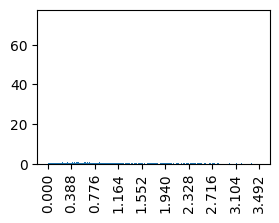

Mean: 0.387286, Variance: 0.352588 Max: 3.491978
Epoch 0, Iter: 50, Loss: 3.9661


In [207]:
train_model_batch(cnn, rnnmodel, batch, captions, num_iter=50, lr=1e-3, batch_size=16, epochs=1)

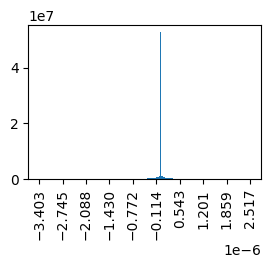

Mean: -0.000000, Variance: 0.000000 Max: 0.000003


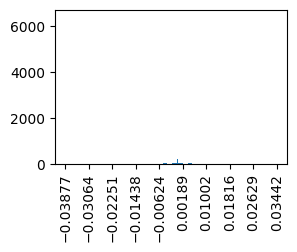

Mean: 0.000000, Variance: 0.000000 Max: 0.034421


In [110]:
def view_weights(weights):
    weights = weights.view(-1).cpu()
    plt.figure(figsize=(3, 2))
    plt.hist((weights).detach().numpy(), bins=500,density=True)  # Increase the number of bins
    ticks = np.linspace(weights.min().item(), weights.max().item(), num=10)
    plt.xticks(ticks, rotation=90)
    plt.show()
    mean = torch.mean(weights)
    variance = torch.var(weights)
    max = torch.max(weights)
    print(f'Mean: {mean:.6f}, Variance: {variance:.6f}', f'Max: {max:.6f}')

    
view_weights(cnn.fc1.weight.grad)
#view_weights(rnnmodel.rnn.all_weights[0][3].grad)
view_weights(rnnmodel.final.weight.grad)

In [92]:
mean = torch.mean(rnnmodel.rnn.all_weights[0][0].grad)
variance = torch.var(rnnmodel.rnn.all_weights[0][0].grad)
mean, variance

(tensor(3.8807e-05, device='cuda:0'), tensor(1.6788e-05, device='cuda:0'))

In [186]:
train_model_batch(cnn, rnnmodel, batch, captions, num_iter=200, lr=1e-3, batch_size=32, epochs=3)


Epoch 0, Iter: 9, Loss: 8.140734815597535
Epoch 0, Iter: 19, Loss: 6.217635011672973
Epoch 0, Iter: 29, Loss: 5.001308822631836
Epoch 0, Iter: 39, Loss: 4.70042986869812
Epoch 0, Iter: 49, Loss: 4.56100549697876
Epoch 0, Iter: 59, Loss: 4.475297927856445
Epoch 0, Iter: 69, Loss: 4.350770473480225
Epoch 0, Iter: 79, Loss: 4.283113646507263
Epoch 0, Iter: 89, Loss: 4.212847661972046
Epoch 0, Iter: 99, Loss: 4.187982797622681
Epoch 0, Iter: 109, Loss: 4.233694314956665
Epoch 0, Iter: 119, Loss: 4.124292087554932
Epoch 0, Iter: 129, Loss: 4.109035849571228
Epoch 0, Iter: 139, Loss: 4.053718829154969
Epoch 0, Iter: 149, Loss: 3.9506239891052246
Epoch 0, Iter: 159, Loss: 3.980092740058899
Epoch 0, Iter: 169, Loss: 3.8637253284454345
Epoch 0, Iter: 179, Loss: 3.9041366577148438
Epoch 0, Iter: 189, Loss: 3.8207947492599486
Epoch 0, Iter: 199, Loss: 3.9141504049301146
Epoch 1, Iter: 9, Loss: 3.8182069301605224
Epoch 1, Iter: 19, Loss: 3.6773332834243773
Epoch 1, Iter: 29, Loss: 3.79734096527099

3.84 at lr= 5e-4

4.52 at lr= 1e-4

3.59 at lr= 1e-3

4.43 at lr= 1e-4

3.61 at lr= 3e-3



In [63]:
a=5e-4
a

0.0005

In [ ]:
cnnv0 = CNNModel(256)
rnnv0 = RNNmodel(512, 256)
cnnv0.to(device)
rnnv0.to(device)
cnnv0.load_state_dict(torch.load('weights/cnn_v0.1.1.pth'))
rnnv0.load_state_dict(torch.load('weights/rnn_v0.1.1.pth'))

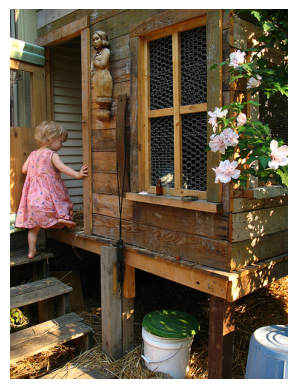

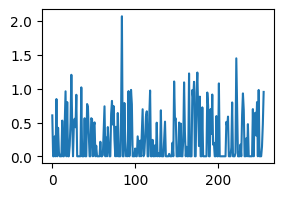

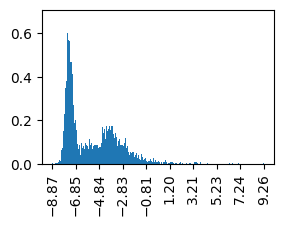

Mean: -5.470280, Variance: 4.910674 Max: 9.256058


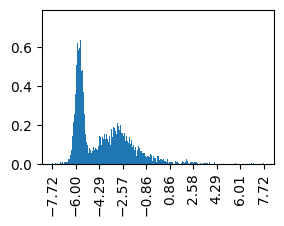

Mean: -4.064730, Variance: 3.868079 Max: 7.724967


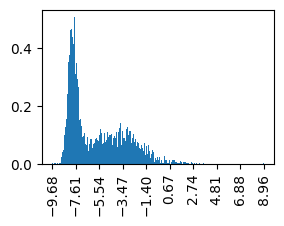

Mean: -5.686015, Variance: 6.245977 Max: 8.955364


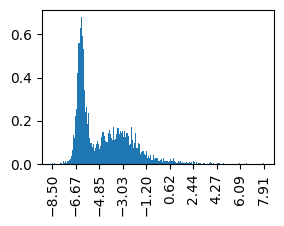

Mean: -4.564574, Variance: 4.288747 Max: 7.911954


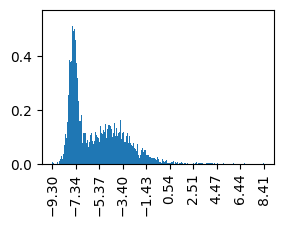

Mean: -5.625339, Variance: 4.924024 Max: 8.411791


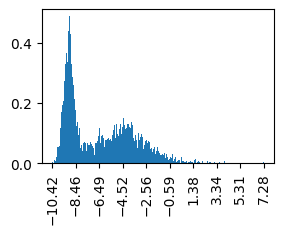

Mean: -6.428517, Variance: 7.685817 Max: 7.276847


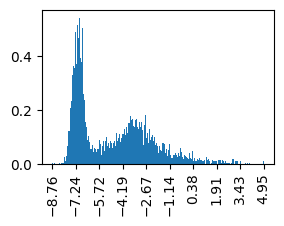

Mean: -4.799315, Variance: 6.043277 Max: 4.953402


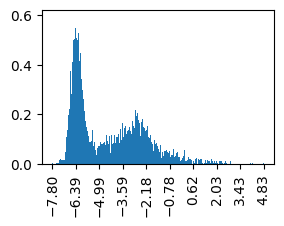

Mean: -4.379795, Variance: 4.533535 Max: 4.831275


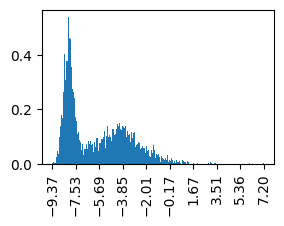

Mean: -5.790147, Variance: 6.073640 Max: 7.197297


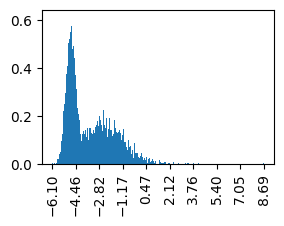

Mean: -3.394039, Variance: 2.629200 Max: 8.692587


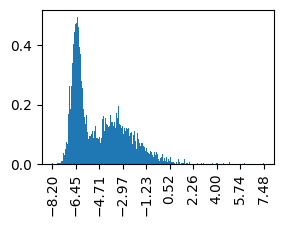

Mean: -4.627484, Variance: 3.970328 Max: 7.484556


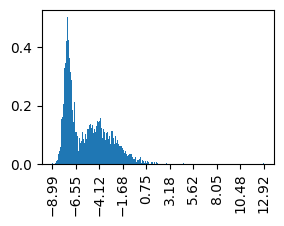

Mean: -5.448020, Variance: 4.648395 Max: 12.916569
Generated Caption: START a black dog runs towards a breaking into its mouth . END


In [105]:
img_name = ann['image'][2]
#img_name = 'test/tree.jpg'
image = resize_image(get_image_data(img_name), (320, 320)).to(device)
display_image(img_name)
caption = sample_caption(cnn, rnnmodel, image)
print("Generated Caption:", caption)

1. Learning rate = 0.3, batch_size = 4, epoch=1, num_train_images = 1000
- Loss = 5.42
2. Learning rate = 0.1, batch_size = 4, epoch=1, num_train_images = 1000
- Loss = 2.71
3. Learning rate = 0.01, batch_size = 4, epoch=1, num_train_images = 1000
- Loss = 1.79
4. Learning rate = 0.003, batch_size = 4, epoch=1, num_train_images = 1000
- Loss = 1.75, training time = 113.5s
5. Learning rate = 0.003, batch_size = 10, epoch=1, num_train_images = 1000
- Loss = 1.867, training time = 62.4s
6. Learning rate = 0.003, batch_size = 20, epoch=1, num_train_images = 1000
- Loss = 2.21, training time = 42.5
7. Learning rate = 0.01, batch_size = 20, epoch=1, num_train_images = 2000
- loss = 1.62, training time = 90s
8. Learning rate = 0.01, batch_size = 32, epoch=1, num_train_images = 3200
- loss = 1.564, training time = 123s
9. Learning rate = 0.01, batch_size = 32, epoch=1, num_train_images = 12800
- loss = 1.24, training time = 8m 27s
9. Learning rate = 0.01, batch_size = 32, epoch=3, num_train_images = 16000
- loss = 1.11, training time = 25m

New Arch v0.1 (4 convs)
1. Learning rate = 0.001, batch_size = 32, epoch = 11, num_train = 16000
- loss = 1.95, training time = 28m

Arch v0.2 (more convs)

1. lr = 1e-3, batch_size = 128, epoch=2, train_all
- loss = 3.1, time = 13m



In [ ]:
torch.save(cnn.state_dict(), 'cnn_v0.1.1.pth')
torch.save(rnnmodel.state_dict(), 'rnn_v0.1.1.pth')

print("Model weights saved successfully.")

Model weights saved successfully.


In [ ]:
testimg = resize_image(get_image_data('test/testimg.jpg'), (320, 320))